In [222]:
import cv2
import glob
import re
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
import tensorflow as tf

### We want to extract every different dish we have in our subfolders

In [8]:
path = "../input/images/"

In [9]:
folders=glob.glob(f'{path}*')

In [10]:
def take_dish_name(path):
    dishes=glob.glob(f'{path}*')
    names=[]
    for dish in dishes:
        names.append(dish.replace(r'../input/images/',''))
    return names

In [11]:
names=take_dish_name(path)

In [96]:
names[0]

'lobster_roll_sandwich'

In [13]:
def pictures_to_df(path="../input/images/"):

    dishes = [
        *glob.glob(f"{path}/**/*.jpg"),
        *glob.glob(f"{path}/**/*.JPG")
    ]
    pictures = pd.DataFrame({
        "path": dishes
    })

    pictures['dish']=pictures.path.apply(lambda x: x.split("/")[3])
    return pictures


In [14]:
pictures=pictures_to_df(path="../input/images/")

In [16]:
le = preprocessing.LabelEncoder()
pictures['dish_ord'] = le.fit_transform(pictures['dish'])

In [17]:
pictures.head()

,path,dish,dish_ord
0,../input/images/lobster_roll_sandwich/2019505.jpg,lobster_roll_sandwich,61
1,../input/images/lobster_roll_sandwich/708911.jpg,lobster_roll_sandwich,61
2,../input/images/lobster_roll_sandwich/784321.jpg,lobster_roll_sandwich,61
3,../input/images/lobster_roll_sandwich/1626426.jpg,lobster_roll_sandwich,61
4,../input/images/lobster_roll_sandwich/849365.jpg,lobster_roll_sandwich,61


### Displaying photos to check them

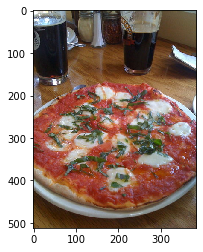

In [18]:
img = Image.open("../input/images/pizza/2965.jpg")
plt.imshow(np.array(img))

In [19]:
pictures_part=pictures[pictures['dish_ord']==0].append(pictures[pictures['dish_ord']==1]).append(pictures[pictures['dish_ord']==2])

In [183]:
pictures_part

,path,dish,dish_ord
95000,../input/images/apple_pie/1147371.jpg,apple_pie,0
95001,../input/images/apple_pie/202741.jpg,apple_pie,0
95002,../input/images/apple_pie/3198655.jpg,apple_pie,0
95003,../input/images/apple_pie/1343307.jpg,apple_pie,0
95004,../input/images/apple_pie/591398.jpg,apple_pie,0
...,...,...,...
90995,../input/images/baklava/3742847.jpg,baklava,2
90996,../input/images/baklava/3300382.jpg,baklava,2
90997,../input/images/baklava/2984698.jpg,baklava,2
90998,../input/images/baklava/3140803.jpg,baklava,2


### We define a generator to use it fot the neural net afterwards

In [131]:
def dataset(label,path="../input/images"):
    def genImg():
        for im in glob.glob(f"{path}/{label}/*.jpg"):
            img = cv2.imread(im)
            img2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            dim=(32,32)
            image=cv2.resize(img2, dim,interpolation=cv2.INTER_AREA)
            yield np.array(image)
    return genImg

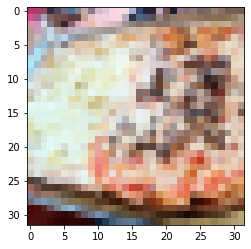

In [132]:
images=dataset(label='pizza')
for _ in range(5):
    plt.figure()
    plt.imshow(next(images()))
    break

In [211]:
photos=tf.data.Dataset.from_tensor_slices([32,32,3])
type(photos)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [185]:
apple_pies=tf.data.Dataset.from_generator(dataset(label='apple_pie'),(tf.int32),[32,32,3])

In [186]:
baby_ribs=apple_pies=tf.data.Dataset.from_generator(dataset(label='baby_back_ribs'),(tf.int32),[32,32,3])

In [187]:
baklavas=tf.data.Dataset.from_generator(dataset(label='baklava'),(tf.int32),[32,32,3])

In [188]:
foods=apple_pies.concatenate(baby_ribs)

In [189]:
foods=foods.concatenate(baklavas)

In [190]:
foods

<ConcatenateDataset shapes: (32, 32, 3), types: tf.int32>

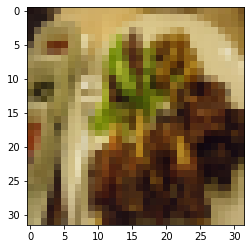

In [204]:
for _ in range(5):
    plt.imshow(next(iter(foods)))

### We create our X_train and X_test to train out neural net for 3 classes (80-20%)


In [234]:
y=pictures_part['dish_ord'].astype(np.int32)

In [253]:
y_test=y[0:600]
y_train=y[600:3000]

In [245]:
X_test = foods.take(600) 
X_train = foods.skip(600)

In [228]:
modelo=Sequential()
steps=3
n_features=1
batch=256
n_clases=10
epocas=50
input_shape=(32,32,3)

In [240]:
modelo=Sequential()
modelo.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                  kernel_initializer='he_normal', input_shape=input_shape))

modelo.add(MaxPooling2D((2,2)))
modelo.add(Dropout(0.25))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2,2)))
modelo.add(Dropout(0.25))
modelo.add(Conv2D(128, (3, 3), activation='relu'))
modelo.add(Dropout(0.4))
modelo.add(Flatten())
modelo.add(Dense(128,  activation='relu'))
modelo.add(Dropout(0.3))
modelo.add(Dense(n_clases, activation='softmax'))


modelo.compile(loss=categorical_crossentropy, 
               optimizer=Adam(), 
               metrics=['accuracy'])

modelo.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)       

In [255]:
modelo.fit(X_train)

ValueError: in user code:

    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/silviaherf/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_11 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [32, 32, 3]


In [246]:
historico=modelo.fit(X_train, y, batch_size=batch, epochs=epocas, verbose=0)

ValueError: `y` argument is not supported when using dataset as input.

### Dividing photos by classes-> para utilizarlo, tendría que hacer con train test split anterior carpetas


### Now, we must define out net typology